# Quantum Sudoku

Our goal here is to use an applicatioan of Grover's Quantum Search Algorithm to identify solutions to a sudoku puzzle. [Sudoku](https://en.wikipedia.org/wiki/Sudoku) is a Japanese puzzle game where a grid of $n^2 \times n^2$ entries are filled with the digits between $1$ and $n^2$. A given configuration of values is a solution to the puzzle if each digit is included exactly once in each row, column, and $n\times n$ sub-grid. One can find solutions by using a version of Grover's Algorithm, which identifies solutions $f(x)=1$ to binary functions of the form $f:\mathbb{Z}_N \rightarrow \mathbb{Z}_2$. In particular, we can map the unknown values of the puzzle onto the Hilbert space of a quantum circuit, with one state for each possible configuration of unknown values. We then apply a quantum circuit that marks valid configurations of the puzzle by amplifying their weight, and suppressing the weight of other configurations. We'll develop the machinery for this starting from a smaller, simpler version of the puzzle, then extend to the full puzzle.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sudoku_functions import *

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator, partial_trace

***

## Mini Sudoku

Let's initially consider a simplified version of the sudoku puzzle, where our puzzle consists of a $2\times 2$ grid 

$$
\left[\begin{array}{c|c}
a & b \\
\hline
c & d \\
\end{array}\right]; \{a,b,c,d\} \in \{0,1\}.
$$

A given configuration to this puzzle is a solution if $a\neq b, a\neq c, b \neq d, c\neq d$; as such there are two solutions given by 
$$
\left[\begin{array}{c|c}
0 & 1 \\
\hline
1 & 0 \\
\end{array}\right] ; 
\left[\begin{array}{c|c}
1 & 0 \\
\hline
0 & 1 \\
\end{array}\right].
$$

We can map the configurations of the puzzle onto the binary forms of the integers $0$ through $15$ with the digits $(a\ b\ c\ d)_2$, meaning the two valid solutions correspond to the states $6 = (0110)_2$ and $9=(1001)_2$.

The Grover's algorithm to find the solutions to this puzzle is roughly as follows:

1. Initialize the system of 4 puzzle qubits to the state $|s\rangle_4 = \mathcal{H}^\otimes 4 |0\rangle_4$, an equal superposition of all possible configurations.
2. Apply the circuit $U$, which checks that all conditions are met for a valid solution, and applies a phase of $-1$ to the states corresponding to valid solutions.
3. Apply the Grover diffuser, which performs an inversion about the mean of the amplitudes of the statevector; this amplifies the amplitudes of the valid solutions and suppresses those of the failed solutions.
4. Repeat steps (2.) and (3.) an appropriate number of times to create the optimal probabilities of a solution.

### State Preparation

We first initialize our system into the state which is an equal superposition of all configurations of the sudoku puzzle; this is accomplished by initializing one qubit for each digit of the puzzle to the state $|0\rangle$, then applying the gate $H$ to each qubit.

In [6]:
## State Preparation Circuit
qr = QuantumRegister(size=4, name = "p");

prep_qc = QuantumCircuit(qr, name = "State Prep");
prep_qc.h(qr);
prep = prep_qc.to_gate();
print(Statevector(prep_qc))
prep_qc.draw()

Statevector([0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
            dims=(2, 2, 2, 2))


┌───┐
p_0: ┤ H ├
     ├───┤
p_1: ┤ H ├
     ├───┤
p_2: ┤ H ├
     ├───┤
p_3: ┤ H ├
     └───┘

### Oracle

Next we need a circuit which tests to determine whether a configuration can be a valid solution or not; this is done by checking that the digits in each space of the puzzle are different. We use one qubit for each space. For each pair of values we need to compare, we use the corresponding qubits as the control for two $CX$ gates targeting the same ancilla; the ancilla is only flipped if the control qubits differ. Then, a multi-controlled phase gate targeting each of the ancilla reverses the overall sign of the state only when every ancilla is flipped. (All the $CX$ gates are reversed afterwards to leave the ancillas unchanged up to overall phase.)

In [8]:
## Oracle Circuit
puzzle_qr = QuantumRegister(size=4, name = "p");
## need one qubit for each check
check_qr = AncillaRegister(size=4, name = "c");

oracle_qc = QuantumCircuit(puzzle_qr, check_qr, name = "Oracle");

## Check that each pair are not equal;
pair_list = [(0,1), (0,2), (1,3), (2,3)];
for c in range(len(pair_list)):
    j,k = pair_list[c];
    ## If bits are different, then check bit is flipped to true
    oracle_qc.cx(puzzle_qr[j], check_qr[c]);
    oracle_qc.cx(puzzle_qr[k], check_qr[c]);

## if all check bits are true, then flip sign
oracle_qc.mcp(np.pi, check_qr[0:-1], check_qr[-1])

## undo checks to put the ancillas back
for c in range(len(pair_list)):
    j,k = pair_list[c];
    oracle_qc.cx(puzzle_qr[j], check_qr[c]);
    oracle_qc.cx(puzzle_qr[k], check_qr[c]);

oracle = oracle_qc.to_gate();
oracle_qc.draw()

»
p_0: ──■─────────■────────────────────────────────────■─────────■────────────»
       │         │                                    │         │            »
p_1: ──┼────■────┼─────────■──────────────────────────┼────■────┼─────────■──»
       │    │    │         │                          │    │    │         │  »
p_2: ──┼────┼────┼────■────┼─────────■────────────────┼────┼────┼────■────┼──»
       │    │    │    │    │         │                │    │    │    │    │  »
p_3: ──┼────┼────┼────┼────┼────■────┼────■───────────┼────┼────┼────┼────┼──»
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │         ┌─┴─┐┌─┴─┐  │    │    │  »
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───■─────┤ X ├┤ X ├──┼────┼────┼──»
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   │     └───┘└───┘┌─┴─┐┌─┴─┐  │  »
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼───■───────────────┤ X ├┤ X ├──┼──»
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │   │               └───┘└───┘┌─┴─┐»
c_2: ────────────────────┤ X ├┤ X ├──┼────┼───■─────────────────────────┤ X ├»
                         └───┘└───┘┌─┴─┐┌─┴─┐ │P(π)                     └───┘»
c_3: ──────────────────────────────┤ X ├┤ X ├─■──────────────────────────────»
                                   └───┘└───┘                                »
«                    
«p_0: ───────────────
«                    
«p_1: ───────────────
«                    
«p_2: ───────■───────
«            │       
«p_3: ──■────┼────■──
«       │    │    │  
«c_0: ──┼────┼────┼──
«       │    │    │  
«c_1: ──┼────┼────┼──
«     ┌─┴─┐  │    │  
«c_2: ┤ X ├──┼────┼──
«     └───┘┌─┴─┐┌─┴─┐
«c_3: ─────┤ X ├┤ X ├
«          └───┘└───┘

### Diffuser

The general Grover diffuser circuit is given by $\left( H^{\otimes N} \right) \left( X^{\otimes N} \right) \left( C^{N-1}Z \right) \left( X^{\otimes N} \right) \left( H^{\otimes N}\right)$; this performs an inversion about the mean of the weights of the input state. Since the (few) valid solutions have had their phase inverted, the mean will be have the opposite sign, and this inversion will amplifies the weight in the valid solution states.

 - Oracle circuit inverts the phase of the solutions:
<img src="diffuser1.png" alt="diffuser_action_1" width="300"/>

 - Diffuser circuit inverts about the mean, amplifying the solutions:
<img src="diffuser2.png" alt="diffuser_action_2" width="300"/>

[Images from Qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb)

In [10]:
## Diffuser Circuit 
qr = QuantumRegister(size=4, name = "p");

diffuser_qc = QuantumCircuit(qr, name = "Diffuser");
diffuser_qc.h(qr);
diffuser_qc.x(qr);
diffuser_qc.mcp(np.pi, qr[0:-1], qr[-1])
diffuser_qc.x(qr);
diffuser_qc.h(qr);

diffuser = diffuser_qc.to_gate();
diffuser_qc.draw()

┌───┐┌───┐       ┌───┐┌───┐
p_0: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │     ├───┤├───┤
p_1: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │     ├───┤├───┤
p_2: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │P(π) ├───┤├───┤
p_3: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     └───┘└───┘       └───┘└───┘

### Full Grover

The final Grover circuit is determined by the applying the state preparation circuit, then repeating the oracle and diffuser until the solution states have the optimal probability.

This optimal probality is found (for systems with $m$ solutions, and $N$ qubits) when we apply the algorithm up to $k = \left\lceil \frac{\pi}{4}\sqrt{\frac{N}{m}} \right\rceil$ times (as per Nielsen & Chuang Eq. (6.17)). Here there are $m=2$ solutions and $N=4$ qubits.

Optimal # of iterations:  3
     ┌─────────────┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─────────┐»
p_0: ┤0            ├┤0        ├┤0          ├┤0        ├┤0          ├┤0        ├»
     │             ││         ││           ││         ││           ││         │»
p_1: ┤1            ├┤1        ├┤1          ├┤1        ├┤1          ├┤1        ├»
     │  State Prep ││         ││  Diffuser ││         ││  Diffuser ││         │»
p_2: ┤2            ├┤2        ├┤2          ├┤2        ├┤2          ├┤2        ├»
     │             ││         ││           ││         ││           ││         │»
p_3: ┤3            ├┤3        ├┤3          ├┤3        ├┤3          ├┤3        ├»
     └─────────────┘│  Oracle │└───────────┘│  Oracle │└───────────┘│  Oracle │»
c_0: ───────────────┤4        ├─────────────┤4        ├─────────────┤4        ├»
                    │         │             │         │             │         │»
c_1: ───────────────┤5        ├─────────────┤5        ├─────────────┤5        ├»


<BarContainer object of 16 artists>

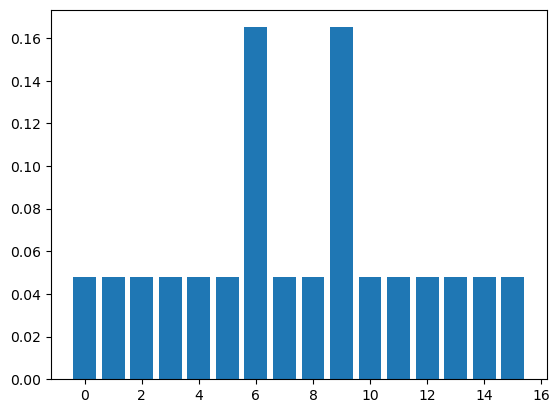

In [12]:
m = 2; N = 4;
niter = int(np.ceil(np.pi/4 * np.sqrt(N/m))); ## N&C 6.17
print("Optimal # of iterations: ",k);

puzzle_qr = QuantumRegister(size=4, name = "p");
check_qr = AncillaRegister(size=4, name = "c");

grover_qc = QuantumCircuit(puzzle_qr, check_qr, name = "Grover");

grover_qc.compose(prep, inplace=True);
for j in range(k):
    grover_qc.compose(oracle, inplace=True);
    grover_qc.compose(diffuser, inplace=True);

print(grover_qc.draw())

psi = Statevector(grover_qc);
rho_p = partial_trace(psi, [j for j in range(4,8)]);

plt.bar(range(2**N), rho_p.probabilities())

Here we can see that the most likely outcomes for the state of the final qubits are the configurations corresponding to the states $6=(0110)_2$ and $9=(1001)_2$, as predicted.

***
## Full Sudoku

In general, the sudoku puzzle is a $n^2 \times n^2$ grid of values $1$ through $n^2$, subdivided into an $n\times n$ array of $n\times n$ subgrids. Each value is used exactly once in each row, column, and subgrid. The smallest version is a $4\times 4$ grid which is filled with the digits $1,2,3,4$, with each digit is used once in each row, column and $2\times 2$ subgrid. Here we simply label the positions in the grid as :

$$
\left[\begin{array}{cc|cc}
0 & 1 & 2 & 3 \\
4 & 5 & 6 & 7 \\
\hline
8 & 9 & 10 & 11 \\
12 & 13 & 14 & 15
\end{array}\right]
$$

### Puzzle Input

1. Enter the value of `n` below for the difficulty of the puzzle
2. Enter the known values into `puzzle_input` with the digits between $1$ and $n^2$.
3. Enter any unknown values into `puzzle_input` as `0`.

In [16]:
## Enter n for dimension of puzzle
n = 2; 

## Enter values between 1 and n^2; leave unknown values as 0s
puzzle_input = np.array([[ 1 , 2 , 4 , 3 ],
                         [ 3 , 0 , 1 , 2 ],
                         [ 2 , 1 , 3 , 4 ],
                         [ 4 , 3 , 2 , 1]]);  

puzzle = process_input(puzzle_input, n);

Qubits needed per unknown value:  2
1 unknown values at positions:  [5]
Puzzle qubits needed:  2


### State Preparation

For each position where the value is unknown, we can encode the values $0$ to $n^2-1$ onto the state of $q \equiv \lceil \log_2(n^2) \rceil$ qubits (one for each binary digit); therefore, for $x$ unknown values, we have $qx$ qubits needed in the main circuit, for up to $qn^4$ puzzle qubits in the case with no known values. We prepare the Grover search by initializing the puzzle qubits into an equal superposition of every basis state.

The prep circuit has $\mathcal{O}(1)$ depth, as we only require one gate regardless of the number of qubits.

In [18]:
prep = create_prep_circuit(puzzle, vis=True);

Puzzle qubits:  2
     ┌───┐
p_0: ┤ H ├
     ├───┤
p_1: ┤ H ├
     └───┘


### Oracle

The oracle needs to identify for each state of the unknown values, which states are valid configurations, and invert the phase of those configurations. It needs to check each row, column, and subgrid which includes a missing value, for up to $3n^2$ checks. Each check is comprised of checking that each pair of values are not equal, for up to $n^2(n^2-1)/2$ inequalities in each check. There are three subroutines we need to accomplish this goal:

 - A way to temporarily map known values onto ancillas for comparison to unknown values in the puzzle
 - A way to compare digits of two particular values by comparing their corresponding qubits
 - A way to verify that for each pair of values, at least one digit differs; logical `OR`

For the first of these, we simply look at the binary representation of the puzzle value at a given position, and apply an X gate to the ancillas that correspond to a $1$. Always remember to undo this operation when you're done with the check at a given position.
 - This circuit acts on $q\sim\mathcal{O}(\log_2(n))$ qubits and has depth $1\sim\mathcal{O}(1)$ depth.

For comparing digits, we can use the same approach as before, where two $CX$ gates flip a target only if the two compared qubits differ. 
 - This circuit acts on $3q\sim\mathcal{O}(\log_2(n))$ qubits and has depth $2\sim\mathcal{O}(1)$.

For the logical `OR`, we use a sequence of $MCX$ gates and $X$ gates acting on incrementally more qubits. The first time a $1$ is found in the input qubits, the output qubit is flipped, then that $1$ is flipped to a $0$, so any future $MCX$ gates can't flip the result bit.
 - This circuit acts on $q+1\sim\mathcal{O}(\log_2(n))$ qubits and has depth $2q\sim\mathcal{O}(\log_2(n))$; 

In [20]:
## Subroutines:
print("Circuit to map known value at puzzle index ",k)
create_map_to_ancilla(puzzle, 2, vis=True);
print("Circuit to compare equality of digits")
create_compare_digits(puzzle, vis=True);
print("Circuit to compute if any of a set of qubits is 1")
create_or(puzzle, vis=True);

Circuit to map known value at puzzle index  3
     ┌───┐
a_0: ┤ X ├
     ├───┤
a_1: ┤ X ├
     └───┘
Circuit to compare equality of digits
                          
dA_0: ──■─────────────────
        │                 
dA_1: ──┼────■────────────
        │    │            
dB_0: ──┼────┼────■───────
        │    │    │       
dB_1: ──┼────┼────┼────■──
      ┌─┴─┐  │  ┌─┴─┐  │  
 c_0: ┤ X ├──┼──┤ X ├──┼──
      └───┘┌─┴─┐└───┘┌─┴─┐
 c_1: ─────┤ X ├─────┤ X ├
           └───┘     └───┘
Circuit to compute if any of a set of qubits is 1
          ┌───┐     ┌───┐
c_0: ──■──┤ X ├──■──┤ X ├
       │  └───┘  │  └───┘
c_1: ──┼─────────■───────
     ┌─┴─┐     ┌─┴─┐     
  r: ┤ X ├─────┤ X ├─────
     └───┘     └───┘     


The full oracle function loops over each row, column, and subgrid which features a missing value (up to $3n^2$). For each one, it compares the digits of each pair of values in that row/colum/grid ($(n^4-n^2)/2$ inequalities) (either digits from the corresponding unknown puzzle qubits, or digits mapped onto the ancilla for known values), checks that the digits differ, and inverts the phase for states which satisfy all checks. After each inequality check or each row/col/grid, that particular portion of the circuit is uncomputed in order to reset the ancillas for the next iteration.

In [22]:
oracle = create_oracle_circuit(puzzle, vis=True)

Need to check rows:  [2]
Need to check columns:  [2]
Need to check grids:  [1]
Puzzle qubits:  2
Known value ancilla qubits:  2
Inequality check qubits :  2  +  6
Row/Col/Grid check qubits:  3

 Total number of qubits:  15
                       ┌────────────────┐       ┌────────────────┐»
p_0: ──────────────────┤2               ├───────┤2               ├»
                       │                │       │                │»
p_1: ──────────────────┤3               ├───────┤3               ├»
     ┌────────────────┐│                │       │                │»
a_0: ┤0               ├┤0               ├───────┤0               ├»
     │  Ancilla Map 2 ││                │       │                │»
a_1: ┤1               ├┤1               ├───────┤1               ├»
     └────────────────┘│                │┌─────┐│                │»
c_0: ──────────────────┤                ├┤2    ├┤                ├»
           ┌───┐       │                ││     ││                │»
c_1: ──────┤ X ├───────┤     

### Diffuser

This is the exact same diffuser circuit as before in the mini Sudoku example, just applied to a different number of qubits depending on how many unknown values are needed.

In [24]:
diffuser = create_diffuser(puzzle, vis=True)

     ┌───┐┌───┐       ┌───┐┌───┐
p_0: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │P(π) ├───┤├───┤
p_1: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     └───┘└───┘       └───┘└───┘


***
### Full Grover

The primary limitation of this circuit is the number of qubits needed for the comparisons; there is an overhead of up to $3n^2 + (n^4-n^2)/2 + 2q$ ancillae needed (with slightly fewer needed, if we can skip checking certain rows/columns/grids). On top of that, we require $qx$ qubits for $x$ missing values in the puzzle, for up to $qn^4$ qubits needed for the puzzle. The depth of the circuit scales similarly, as the inequality checks are done in serial (thought one could possibly do independent pairs in parallel for a small speedup).

*NB:* This took on the order of ~10 minutes to run on my laptop for a circuit with ~18 qubits; increasing the number of qubits exponentially increases the time it takes to run. 

Optimal # of iterations:  2

 Total number of qubits:  15
Figure(640x480)

 Possible Solution: 
 [[1 2 4 3]
 [3 4 1 2]
 [2 1 3 4]
 [4 3 2 1]]


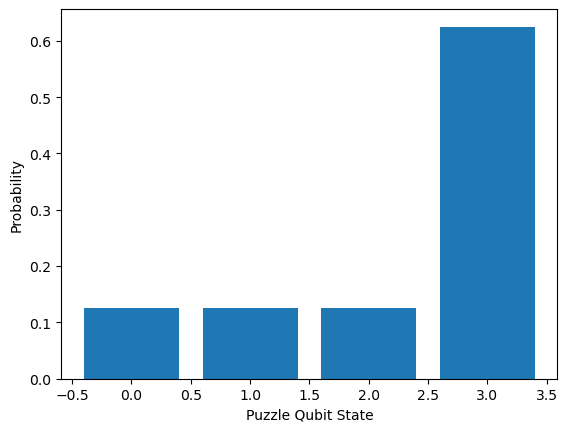

In [26]:
m = 1; N = 4;
niter = int(np.ceil(np.pi/4 * np.sqrt(N/m))); ## N&C 6.17
print("Optimal # of iterations: ",niter);

grover_qc = create_grover(puzzle, niter, vis=False)

answers, histogram = process_solutions(puzzle, grover_qc);

***
# Acknowledgements

Much of the early discussion and implementation of the mini-Sudoku algorithm draws from [this old online Qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb), as well as the diagrams for the diffuser circuits. Some of the Python syntax/code used here was developed with the aid of Microsoft Copilot, as well as heavy reference to the [Qiskit Documentation](https://docs.quantum.ibm.com).